In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [1]:

# Load datasets (train and test data)
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Feature engineering: Categorize departure delays into 4 categories
def categorize_delay(x):
    if x == 0:
        return 'No Delay'
    elif x < 45:
        return 'Short Delay'
    elif 45 <= x <= 175:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

# Apply delay categorization
train_df['multi_target'] = train_df['departure.delay_minutes'].apply(categorize_delay)

# Select relevant features based on domain knowledge
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Humidity (%) Max', 'Humidity (%) Avg',
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Pressure (in) Max', 'Pressure (in) Avg'
]

categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode', 'departure.day_of_week', 'departure.hour_of_day'
]

# Prepare the features and target variable for multi-class classification
X_multi = train_df[numeric_features + categorical_features]
y_multi = train_df['multi_target']

# Split data into training and validation sets (80% train, 20% validation)
X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# Preprocessing pipeline: Handle missing values, scale numeric features, one-hot encode categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing for both numeric and categorical data using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that includes the preprocessor and the Support Vector Machine classifier
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

In [3]:


# Hyperparameter tuning using GridSearch for SVC
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],  # Regularization parameter
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
    'classifier__kernel': ['rbf'],  # Using the RBF kernel
    'classifier__degree': [3, 5],  # Degree of the polynomial kernel (if using poly)
}

grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train_multi, y_train_multi)

# Output the best parameters from GridSearchCV
print("Best Params for SVM:", grid_search_svm.best_params_)

# Best model from GridSearchCV
best_svm_model = grid_search_svm.best_estimator_

# Cross-validation on the best model
cv_scores_svm = cross_val_score(best_svm_model, X_multi, y_multi, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy:", cv_scores_svm)
print("Mean Accuracy:", cv_scores_svm.mean())

# Predictions on the validation set
y_pred_multi = best_svm_model.predict(X_val_multi)

# Evaluate the model performance for multi-class classification
print("Multi-Class Classification Accuracy:", accuracy_score(y_val_multi, y_pred_multi))
print("Classification Report:\n", classification_report(y_val_multi, y_pred_multi))
print("Confusion Matrix:\n", confusion_matrix(y_val_multi, y_pred_multi))

# Predictions on the test dataset for Kaggle submission
X_test = test_df[numeric_features + categorical_features]
X_test_processed = preprocessor.transform(X_test)  # Apply preprocessing to test set

# Make predictions on the test dataset
y_pred_test = best_svm_model.predict(X_test_processed)

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # ID starting from 1 to 12914
    'Delay': y_pred_test  # Predicted delay categories (No Delay, Short Delay, etc.)
})

# Ensure the number of entries is exactly 12914 (for Kaggle submission)
submission_df = submission_df.head(12914)

# Save the submission file in the required format
submission_df.to_csv('kaggle_submission_svm.csv', index=False)

print("Submission file 'kaggle_submission_svm.csv' saved.")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params for SVM: {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


NameError: name 'cross_val_score' is not defined

In [5]:
from sklearn.model_selection import cross_val_score


In [7]:

# Cross-validation on the best model
cv_scores_svm = cross_val_score(best_svm_model, X_multi, y_multi, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy:", cv_scores_svm)
print("Mean Accuracy:", cv_scores_svm.mean())

# Predictions on the validation set
y_pred_multi = best_svm_model.predict(X_val_multi)

# Evaluate the model performance for multi-class classification
print("Multi-Class Classification Accuracy:", accuracy_score(y_val_multi, y_pred_multi))
print("Classification Report:\n", classification_report(y_val_multi, y_pred_multi))
print("Confusion Matrix:\n", confusion_matrix(y_val_multi, y_pred_multi))

# Predictions on the test dataset for Kaggle submission
X_test = test_df[numeric_features + categorical_features]
X_test_processed = preprocessor.transform(X_test)  # Apply preprocessing to test set

# Make predictions on the test dataset
y_pred_test = best_svm_model.predict(X_test_processed)

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # ID starting from 1 to 12914
    'Delay': y_pred_test  # Predicted delay categories (No Delay, Short Delay, etc.)
})

# Ensure the number of entries is exactly 12914 (for Kaggle submission)
submission_df = submission_df.head(12914)

# Save the submission file in the required format
submission_df.to_csv('kaggle_submission_svm.csv', index=False)

print("Submission file 'kaggle_submission_svm.csv' saved.")


SVM Cross-Validation Accuracy: [0.47710843 0.64941199 0.53248506 0.33969539 0.52255639]
Mean Accuracy: 0.5042514534714916
Multi-Class Classification Accuracy: 0.7135421686746988
Classification Report:
                 precision    recall  f1-score   support

    Long Delay       0.11      0.00      0.01       229
Moderate Delay       0.20      0.01      0.02       625
      No Delay       0.62      0.44      0.51      2793
   Short Delay       0.74      0.92      0.82      6728

      accuracy                           0.71     10375
     macro avg       0.42      0.34      0.34     10375
  weighted avg       0.66      0.71      0.67     10375

Confusion Matrix:
 [[   1    3   86  139]
 [   0    5  132  488]
 [   5    4 1229 1555]
 [   3   13  544 6168]]


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Predictions on the test dataset for Kaggle submission
X_test = test_df[numeric_features + categorical_features]
X_test_processed = preprocessor.transform(X_test)  # Apply preprocessing to test set

# Make predictions on the test dataset
y_pred_test = best_svm_model.predict(X_test_processed)

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # ID starting from 1 to 12914
    'Delay': y_pred_test  # Predicted delay categories (No Delay, Short Delay, etc.)
})

# Ensure the number of entries is exactly 12914 (for Kaggle submission)
submission_df = submission_df.head(12914)

# Save the submission file in the required format
submission_df.to_csv('kaggle_submission_svm.csv', index=False)

print("Submission file 'kaggle_submission_svm.csv' saved.")


In [19]:
# Fit the SVM pipeline on the training data
svm_pipeline.fit(X_train_multi, y_train_multi)

# Transform and predict on the test data
X_test = test_df[numeric_features + categorical_features]
y_pred_test = svm_pipeline.predict(X_test)


In [27]:

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # ID starting from 1 to 12914
    'Delay': y_pred_test  # Predicted delay categories (No Delay, Short Delay, etc.)
})

# Ensure the number of entries is exactly 12914 (for Kaggle submission)
submission_df = submission_df.head(12914)

# Save the submission file in the required format
submission_df.to_csv('kaggle_submission_svm.csv', index=False)

print("Submission file 'kaggle_submission_svm.csv' saved.")


Submission file 'kaggle_submission_svm.csv' saved.


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number              51871 non-null  int

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14982 entries, 0 to 14981
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     14982 non-null  int64  
 1   departure.iataCode         14982 non-null  object 
 2   departure.icaoCode         14982 non-null  object 
 3   departure.scheduledTime    14982 non-null  object 
 4   departure.estimatedRunway  8730 non-null   object 
 5   departure.actualRunway     14982 non-null  object 
 6   arrival.scheduledTime      14982 non-null  object 
 7   arrival.estimatedTime      8429 non-null   object 
 8   airline.iataCode           14976 non-null  object 
 9   airline.icaoCode           14981 non-null  object 
 10  flight.number              14982 non-null  int64  
 11  flight.iataNumber          14976 non-null  object 
 12  flight.icaoNumber          14981 non-null  object 
 13  departure.terminal         14982 non-null  obj

In [31]:
test_sub_file=pd.read_csv('Multi_Test_File.csv')
test_sub_file

,File Name,Flight Number,Type,Status,Departure IATA Code,Departure ICAO Code,Scheduled Time,Arrival IATA Code,Arrival ICAO Code,Arrival Estimated Time
0,20.docx,4361,departure,active,lhe,opla,2024-05-14t00:20:00.000,dxb,omdb,2024-05-14t00:20:00.000
1,20.docx,1876,departure,active,lhe,opla,2024-05-07t04:15:00.000,ruh,oerk,2024-05-07t04:15:00.000
2,20.docx,6030,departure,active,lhe,opla,2024-05-09t03:10:00.000,doh,othh,2024-05-09t03:10:00.000
3,20.docx,739,departure,active,lhe,opla,2024-05-12t02:50:00.000,jed,oejn,2024-05-12t02:50:00.000
4,20.docx,3932,departure,active,lhe,opla,2024-05-16t04:35:00.000,auh,omaa,2024-05-16t04:35:00.000
...,...,...,...,...,...,...,...,...,...,...
12909,71.docx,615,departure,active,isb,opis,2024-06-23t09:30:00.000,doh,othh,2024-06-23t09:30:00.000
12910,71.docx,725,departure,active,isb,opis,2024-06-25t09:50:00.000,ruh,oerk,2024-06-25t10:45:00.000
12911,71.docx,211,departure,active,isb,opis,2024-06-22t15:35:00.000,dxb,omdb,2024-06-22t15:58:00.000
12912,71.docx,207,departure,active,isb,opis,2024-06-19t17:00:00.000,khi,opkc,2024-06-19t18:00:00.000


In [33]:
test_sub_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12914 entries, 0 to 12913
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   File Name               12914 non-null  object
 1   Flight Number           12914 non-null  int64 
 2   Type                    12914 non-null  object
 3   Status                  12914 non-null  object
 4   Departure IATA Code     12914 non-null  object
 5   Departure ICAO Code     12914 non-null  object
 6   Scheduled Time          12914 non-null  object
 7   Arrival IATA Code       12914 non-null  object
 8   Arrival ICAO Code       12914 non-null  object
 9   Arrival Estimated Time  12914 non-null  object
dtypes: int64(1), object(9)
memory usage: 1009.0+ KB


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf', 'linear']
}

# Apply GridSearchCV
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_multi, y_train_multi)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(test_df[numeric_features + categorical_features])


In [38]:
# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score



# Optional: For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

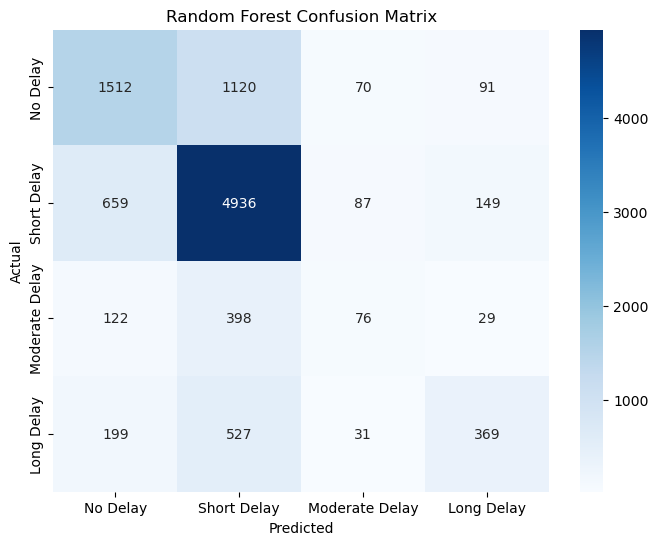

Accuracy: 0.6644
ROC-AUC Score (Macro): 0.8146

Training and evaluating model: Decision Tree

Classification Report for Decision Tree:
                precision    recall  f1-score   support

    Long Delay       0.55      0.56      0.56      1126
Moderate Delay       0.38      0.36      0.37       625
      No Delay       0.60      0.58      0.59      2793
   Short Delay       0.75      0.76      0.75      5831

      accuracy                           0.67     10375
     macro avg       0.57      0.57      0.57     10375
  weighted avg       0.67      0.67      0.67     10375



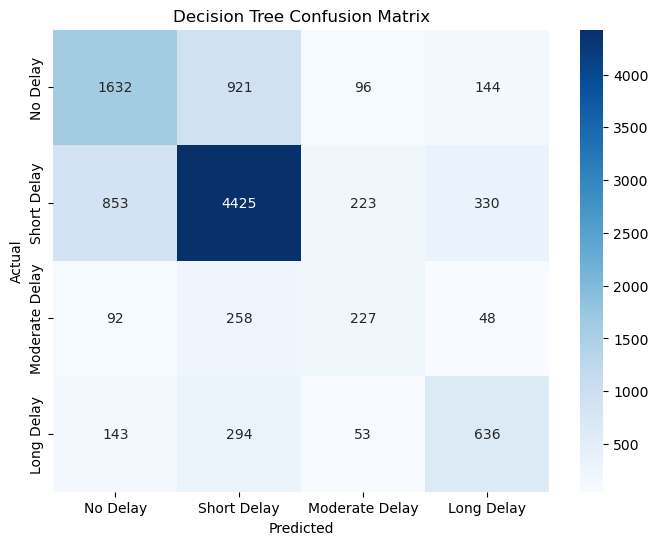

Accuracy: 0.6670
ROC-AUC Score (Macro): 0.7142

Training and evaluating model: Perceptron
Model Perceptron does not support predict_proba. Skipping ROC-AUC.

Classification Report for Perceptron:
                precision    recall  f1-score   support

    Long Delay       0.16      0.12      0.14      1126
Moderate Delay       0.08      0.05      0.06       625
      No Delay       0.44      0.31      0.37      2793
   Short Delay       0.62      0.76      0.68      5831

      accuracy                           0.53     10375
     macro avg       0.33      0.31      0.31     10375
  weighted avg       0.49      0.53      0.50     10375



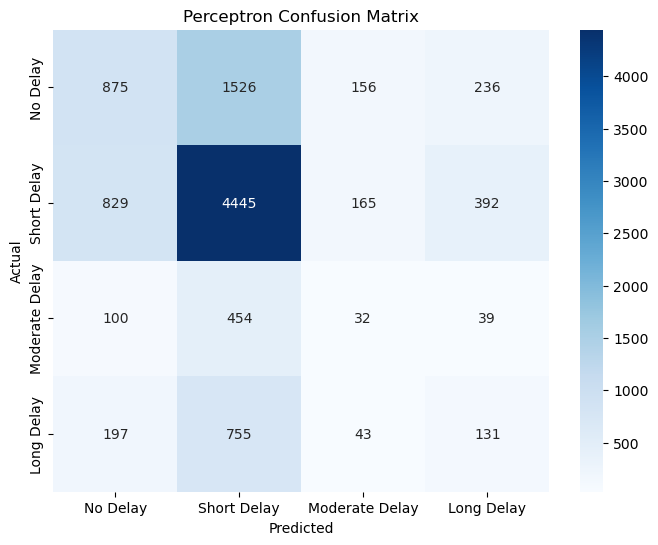

Accuracy: 0.5285
ROC-AUC Score: Not Available

Model Performance Comparison:
           Model  Accuracy  ROC-AUC (Macro)  Precision (Macro)  \
0  Random Forest  0.664386         0.814645           0.545013   
1  Decision Tree  0.666988         0.714221           0.569611   
2     Perceptron  0.528482              NaN           0.325333   

   Recall (Macro)  F1-Score (Macro)  
0        0.459293          0.483015  
1        0.567806          0.568607  
2        0.310782          0.311791  


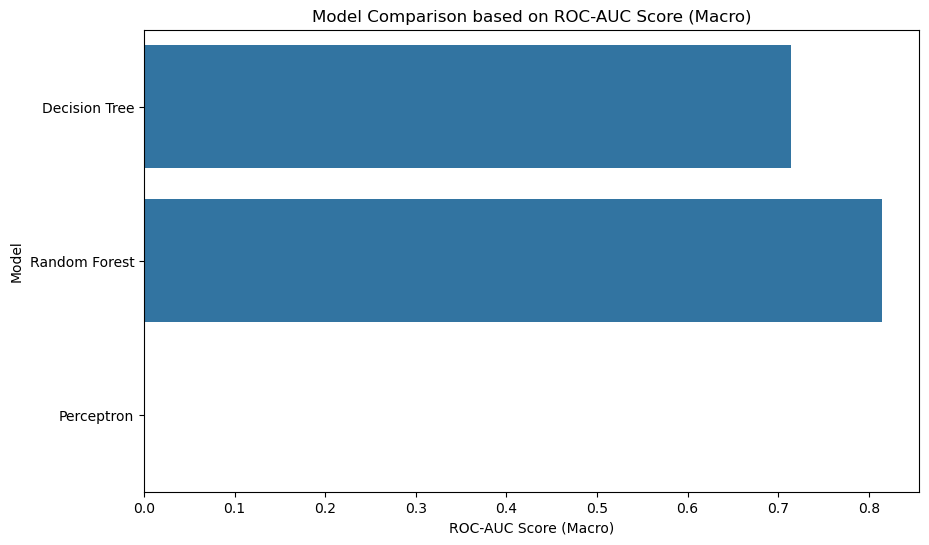

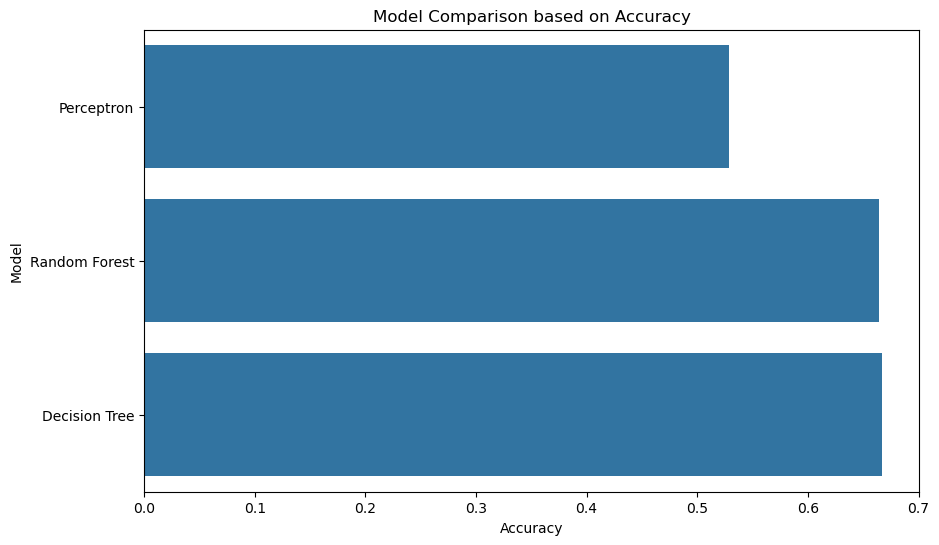


Best Model Selected: Random Forest with ROC-AUC Score: 0.8146

Making predictions on the test dataset using the best model: Random Forest

Delay Category Distribution in Test Predictions:
Delay
Short Delay       9686
No Delay          4097
Long Delay         873
Moderate Delay     326
Name: count, dtype: int64

Submission has the expected number of entries.
Submission file 'kaggle_submission_classification.csv' saved.
Trained Random Forest model saved as 'best_model_random_forest.pkl'.


In [40]:
# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier, DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support
)

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------
# 2. Load Datasets
# ---------------------------------------------

# Replace with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 3. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 4. Datetime Conversion
# ---------------------------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 5. Feature Engineering: Extract Datetime Features
# ---------------------------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes (Removed to prevent data leakage)
    # df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    # df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# ---------------------------------------------
# 6. Define Feature Lists
# ---------------------------------------------

# Define numeric features (excluding 'calculated_departure_delay' to prevent data leakage)
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday'
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# ---------------------------------------------
# 7. Handle Missing Values and Define Preprocessing Pipelines
# ---------------------------------------------

# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ---------------------------------------------
# 8. Define Target Variable for Multi-Class Classification
# ---------------------------------------------

# Define multi-class target variable based on delay minutes
def categorize_delay(minutes):
    if minutes == 0:
        return 'No Delay'
    elif 0 < minutes < 45:
        return 'Short Delay'
    elif 45 <= minutes <= 175:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

train_df['multi_target'] = train_df['departure.delay_minutes'].apply(categorize_delay)

# Verify the distribution
print("\nMulti-Class Target Distribution:")
print(train_df['multi_target'].value_counts())

# Define feature matrix X and target vector y
X = train_df[numeric_features + categorical_features]
y = train_df['multi_target']  # Multi-class target

# Check for missing values in the target variable
missing_targets = y.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the multi-class target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y.dropna().index
    X = X.loc[non_null_indices]
    y = y.loc[non_null_indices]
else:
    print("\nNo missing values found in the multi-class target variable.")

# ---------------------------------------------
# 9. Split Data into Training and Validation Sets
# ---------------------------------------------

# Split the data into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", test_df.shape)

# ---------------------------------------------
# 10. Define and Train Classification Models
# ---------------------------------------------

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Perceptron': OneVsRestClassifier(Perceptron(random_state=42))
}

# Dictionary to store model performances
model_performance = {}

# Iterate through models, train, and evaluate
for model_name, model in models.items():
    print(f"\nTraining and evaluating model: {model_name}")
    
    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)
    
    # For ROC-AUC, we need probability estimates
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_val)
        # Compute ROC-AUC using one-vs-rest
        roc_auc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, average='macro', multi_class='ovr')
    else:
        # Perceptron does not support predict_proba
        y_pred_proba = None
        roc_auc = np.nan
        print(f"Model {model_name} does not support predict_proba. Skipping ROC-AUC.")
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, average='macro', multi_class='ovr')
    else:
        roc_auc = np.nan  # Assign NaN if ROC-AUC not available
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')
    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_val, y_pred, average=None, labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])
    
    # Store performance
    model_performance[model_name] = {
        'Pipeline': pipeline,
        'Accuracy': accuracy,
        'ROC-AUC (Macro)': roc_auc,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1-Score (Macro)': f1,
        'Precision_Class': precision_class,
        'Recall_Class': recall_class
    }
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'],
                yticklabels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC Score (Macro): {roc_auc:.4f}")
    else:
        print("ROC-AUC Score: Not Available")

# ---------------------------------------------
# 11. Compare Models and Select the Best One
# ---------------------------------------------

# Create a DataFrame for model comparison
performance_df = pd.DataFrame({
    'Model': list(model_performance.keys()),
    'Accuracy': [model_performance[m]['Accuracy'] for m in model_performance],
    'ROC-AUC (Macro)': [model_performance[m]['ROC-AUC (Macro)'] for m in model_performance],
    'Precision (Macro)': [model_performance[m]['Precision (Macro)'] for m in model_performance],
    'Recall (Macro)': [model_performance[m]['Recall (Macro)'] for m in model_performance],
    'F1-Score (Macro)': [model_performance[m]['F1-Score (Macro)'] for m in model_performance]
})

print("\nModel Performance Comparison:")
print(performance_df.sort_values(by='ROC-AUC (Macro)', ascending=False))

# Visualization: ROC-AUC Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='ROC-AUC (Macro)', y='Model', data=performance_df.sort_values(by='ROC-AUC (Macro)', ascending=True))
plt.title('Model Comparison based on ROC-AUC Score (Macro)')
plt.xlabel('ROC-AUC Score (Macro)')
plt.ylabel('Model')
plt.show()

# Visualization: Accuracy Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=performance_df.sort_values(by='Accuracy', ascending=True))
plt.title('Model Comparison based on Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Select the best model based on ROC-AUC
performance_df_sorted = performance_df.dropna(subset=['ROC-AUC (Macro)']).sort_values(by='ROC-AUC (Macro)', ascending=False)
best_model_name = performance_df_sorted.iloc[0]['Model']
best_model_pipeline = model_performance[best_model_name]['Pipeline']

print(f"\nBest Model Selected: {best_model_name} with ROC-AUC Score: {model_performance[best_model_name]['ROC-AUC (Macro)']:.4f}")

# ---------------------------------------------
# 12. Make Predictions on the Test Dataset
# ---------------------------------------------

# Make predictions using the best model
print(f"\nMaking predictions on the test dataset using the best model: {best_model_name}")
y_pred_test = best_model_pipeline.predict(test_df[numeric_features + categorical_features])

# ---------------------------------------------
# 13. Prepare the Submission File
# ---------------------------------------------

# Prepare the Submission DataFrame
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Adjust if your test set has specific IDs
    'Delay': y_pred_test  # Predicted delay categories as strings
})

# Verify the distribution
print("\nDelay Category Distribution in Test Predictions:")
print(submission_df['Delay'].value_counts())

# Ensure the Number of Entries matches the expected number
expected_entries = 12914  # Replace with actual expected number if different
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected number of entries.")

# Save the Submission File in the Required Format
submission_df.to_csv('kaggle_submission_classification.csv', index=False)
print("Submission file 'kaggle_submission_classification.csv' saved.")

# ---------------------------------------------
# 14. Save the Best Model
# ---------------------------------------------

# Save the trained best model using joblib
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model_pipeline, model_filename)
print(f"Trained {best_model_name} model saved as '{model_filename}'.")


In [42]:
# Ensure the Number of Entries matches the expected number
expected_entries = 12914  # Replace with actual expected number if different
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected number of entries.")

# Save the Submission File in the Required Format
submission_df.to_csv('multi_classificaion_kaggle_submission_classification_.csv', index=False)
print("Submission file 'kaggle_submission_classification.csv' saved.")

# ---------------------------------------------
# 14. Save the Best Model
# ---------------------------------------------

# Save the trained best model using joblib
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model_pipeline, model_filename)
print(f"Trained {best_model_name} model saved as '{model_filename}'.")



Trimming submission from 14982 to 12914 entries.
Submission file 'kaggle_submission_classification.csv' saved.
Trained Random Forest model saved as 'best_model_random_forest.pkl'.


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

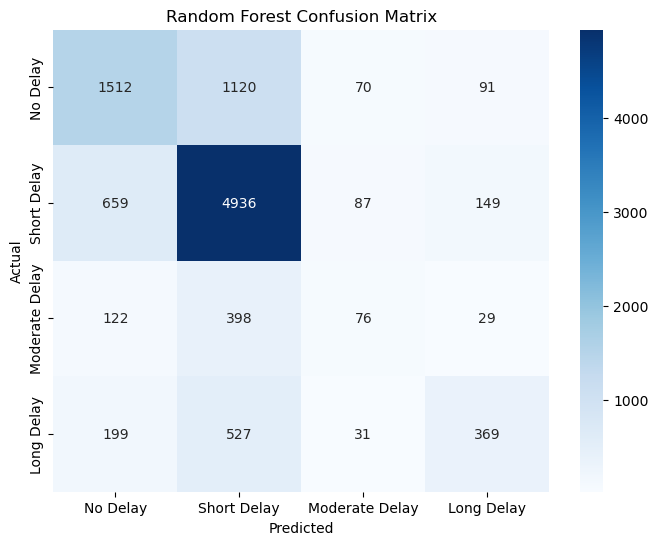

Accuracy: 0.6644
ROC-AUC Score (Macro): 0.8146

Training and evaluating model: Decision Tree

Classification Report for Decision Tree:
                precision    recall  f1-score   support

    Long Delay       0.55      0.56      0.56      1126
Moderate Delay       0.38      0.36      0.37       625
      No Delay       0.60      0.58      0.59      2793
   Short Delay       0.75      0.76      0.75      5831

      accuracy                           0.67     10375
     macro avg       0.57      0.57      0.57     10375
  weighted avg       0.67      0.67      0.67     10375



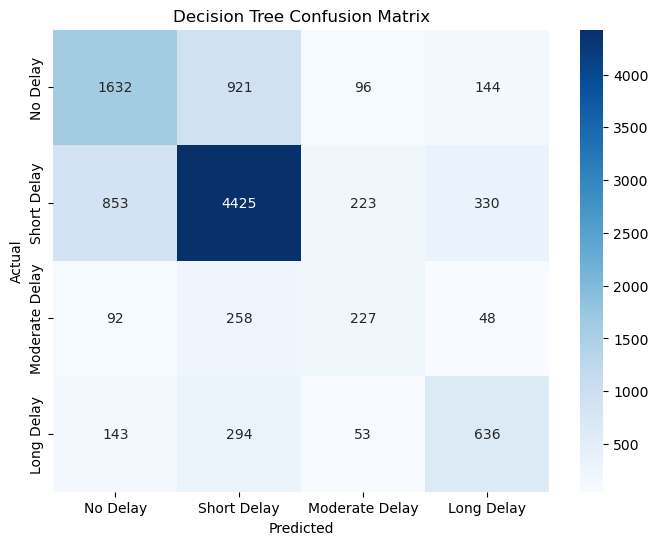

Accuracy: 0.6670
ROC-AUC Score (Macro): 0.7142

Training and evaluating model: Perceptron
Model Perceptron does not support predict_proba. Skipping ROC-AUC.

Classification Report for Perceptron:
                precision    recall  f1-score   support

    Long Delay       0.13      0.08      0.10      1126
Moderate Delay       0.13      0.18      0.15       625
      No Delay       0.43      0.40      0.41      2793
   Short Delay       0.63      0.67      0.65      5831

      accuracy                           0.51     10375
     macro avg       0.33      0.33      0.33     10375
  weighted avg       0.49      0.51      0.50     10375



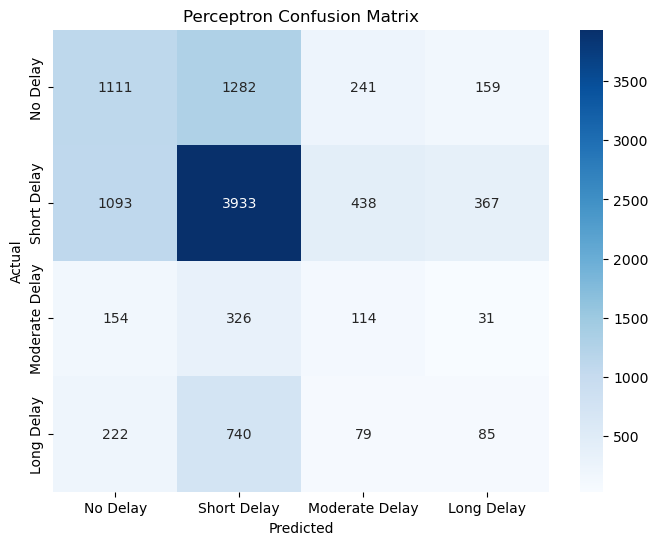

Accuracy: 0.5053
ROC-AUC Score: Not Available

Model Performance Comparison:
           Model  Accuracy  ROC-AUC (Macro)  Precision (Macro)  \
0  Random Forest  0.664386         0.814645           0.545013   
1  Decision Tree  0.666988         0.714221           0.569611   
2     Perceptron  0.505349              NaN           0.329982   

   Recall (Macro)  F1-Score (Macro)  
0        0.459293          0.483015  
1        0.567806          0.568607  
2        0.332542          0.327862  


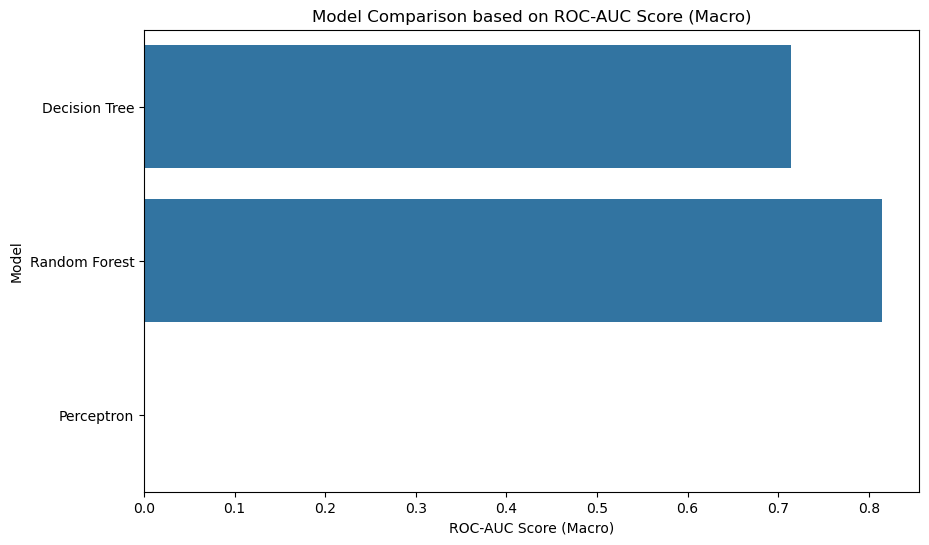

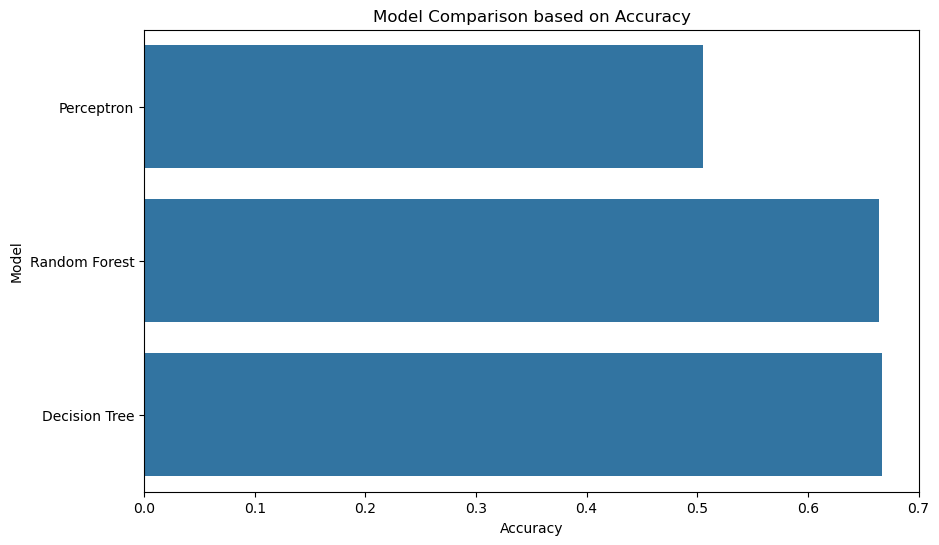


Best Model Selected: Random Forest with ROC-AUC Score: 0.8146

Making predictions on the test dataset using the best model: Random Forest

Delay Category Distribution in Test Predictions:
Delay
Short Delay       9686
No Delay          4097
Long Delay         873
Moderate Delay     326
Name: count, dtype: int64

Trimming submission from 14982 to 12914 entries.
Submission file 'kaggle_submission_classification.csv' saved.
Trained Random Forest model saved as 'best_model_random_forest.pkl'.


In [50]:
# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Optional: For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------
# 2. Load Datasets
# ---------------------------------------------
# Replace with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 3. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------
# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 4. Datetime Conversion
# ---------------------------------------------
# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 5. Feature Engineering: Extract Datetime Features
# ---------------------------------------------
# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday

    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# ---------------------------------------------
# 6. Define Feature Lists
# ---------------------------------------------
# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min',
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min',
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min',
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min',
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday']

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode']

# ---------------------------------------------
# 7. Handle Missing Values and Define Preprocessing Pipelines
# ---------------------------------------------
# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ---------------------------------------------
# 8. Define Target Variable for Multi-Class Classification
# ---------------------------------------------
# Define multi-class target variable based on delay minutes
def categorize_delay(minutes):
    if minutes == 0:
        return 'No Delay'
    elif 0 < minutes < 45:
        return 'Short Delay'
    elif 45 <= minutes <= 175:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

train_df['multi_target'] = train_df['departure.delay_minutes'].apply(categorize_delay)

# Verify the distribution
print("\nMulti-Class Target Distribution:")
print(train_df['multi_target'].value_counts())

# Define feature matrix X and target vector y
X = train_df[numeric_features + categorical_features]
y = train_df['multi_target']  # Multi-class target

# Check for missing values in the target variable
missing_targets = y.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the multi-class target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y.dropna().index
    X = X.loc[non_null_indices]
    y = y.loc[non_null_indices]
else:
    print("\nNo missing values found in the multi-class target variable.")

# ---------------------------------------------
# 9. Split Data into Training and Validation Sets
# ---------------------------------------------
# Split the data into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", test_df.shape)

# ---------------------------------------------
# 10. Define and Train Classification Models
# ---------------------------------------------
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Perceptron': Perceptron(random_state=42)
}

# Dictionary to store model performances
model_performance = {}

# Iterate through models, train, and evaluate
for model_name, model in models.items():
    print(f"\nTraining and evaluating model: {model_name}")

    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)

    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)

    # For ROC-AUC, we need probability estimates
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_val)
        # Compute ROC-AUC using one-vs-rest
        roc_auc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, average='macro', multi_class='ovr')
    else:
        # Perceptron does not support predict_proba
        y_pred_proba = None
        roc_auc = np.nan
        print(f"Model {model_name} does not support predict_proba. Skipping ROC-AUC.")

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, average='macro', multi_class='ovr')
    else:
        roc_auc = np.nan  # Assign NaN if ROC-AUC not available

    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')
    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_val, y_pred, average=None, labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])

    # Store performance
    model_performance[model_name] = {
        'Pipeline': pipeline,
        'Accuracy': accuracy,
        'ROC-AUC (Macro)': roc_auc,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1-Score (Macro)': f1,
        'Precision_Class': precision_class,
        'Recall_Class': recall_class
    }

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'],
                yticklabels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC Score (Macro): {roc_auc:.4f}")
    else:
        print("ROC-AUC Score: Not Available")

# ---------------------------------------------
# 11. Compare Models and Select the Best One
# ---------------------------------------------
# Create a DataFrame for model comparison
performance_df = pd.DataFrame({
    'Model': list(model_performance.keys()),
    'Accuracy': [model_performance[m]['Accuracy'] for m in model_performance],
    'ROC-AUC (Macro)': [model_performance[m]['ROC-AUC (Macro)'] for m in model_performance],
    'Precision (Macro)': [model_performance[m]['Precision (Macro)'] for m in model_performance],
    'Recall (Macro)': [model_performance[m]['Recall (Macro)'] for m in model_performance],
    'F1-Score (Macro)': [model_performance[m]['F1-Score (Macro)'] for m in model_performance]
})

print("\nModel Performance Comparison:")
print(performance_df.sort_values(by='ROC-AUC (Macro)', ascending=False))

# Visualization: ROC-AUC Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='ROC-AUC (Macro)', y='Model', data=performance_df.sort_values(by='ROC-AUC (Macro)', ascending=True))
plt.title('Model Comparison based on ROC-AUC Score (Macro)')
plt.xlabel('ROC-AUC Score (Macro)')
plt.ylabel('Model')
plt.show()

# Visualization: Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=performance_df.sort_values(by='Accuracy', ascending=True))
plt.title('Model Comparison based on Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Select the best model based on ROC-AUC
performance_df_sorted = performance_df.dropna(subset=['ROC-AUC (Macro)']).sort_values(by='ROC-AUC (Macro)', ascending=False)
best_model_name = performance_df_sorted.iloc[0]['Model']
best_model_pipeline = model_performance[best_model_name]['Pipeline']

print(f"\nBest Model Selected: {best_model_name} with ROC-AUC Score: {model_performance[best_model_name]['ROC-AUC (Macro)']:.4f}")

# ---------------------------------------------
# 12. Make Predictions on the Test Dataset
# ---------------------------------------------
# Make predictions using the best model
print(f"\nMaking predictions on the test dataset using the best model: {best_model_name}")
y_pred_test = best_model_pipeline.predict(test_df[numeric_features + categorical_features])

# ---------------------------------------------
# 13. Prepare the Submission File
# ---------------------------------------------
# Prepare the Submission DataFrame
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Adjust if your test set has specific IDs
    'Delay': y_pred_test  # Predicted delay categories as strings
})

# Verify the distribution
print("\nDelay Category Distribution in Test Predictions:")
print(submission_df['Delay'].value_counts())

# Ensure the Number of Entries matches the expected number
expected_entries = 12914  # Replace with actual expected number if different
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected number of entries.")

# Save the Submission File in the Required Format
submission_df.to_csv('kaggle_submission_classification.csv', index=False)
print("Submission file 'kaggle_submission_classification.csv' saved.")

# ---------------------------------------------
# 14. Save the Best Model
# ---------------------------------------------
# Save the trained best model using joblib
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model_pipeline, model_filename)
print(f"Trained {best_model_name} model saved as '{model_filename}'.")

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

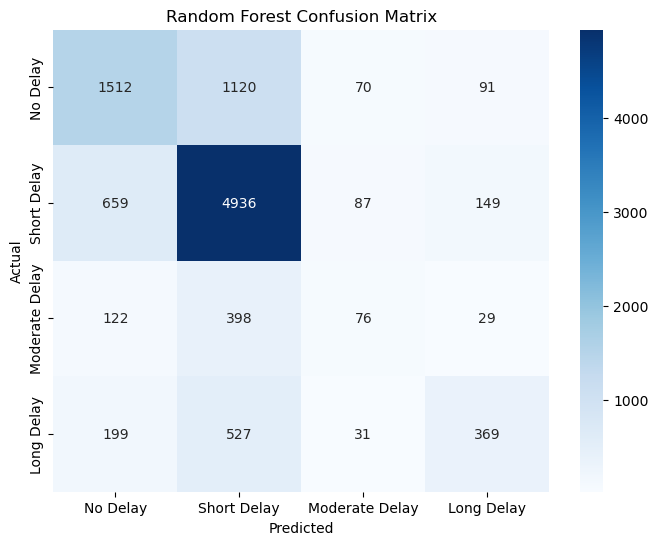

Accuracy: 0.6644
ROC-AUC Score (Macro): 0.8146

Training and evaluating model: Decision Tree

Classification Report for Decision Tree:
                precision    recall  f1-score   support

    Long Delay       0.55      0.56      0.56      1126
Moderate Delay       0.38      0.36      0.37       625
      No Delay       0.60      0.58      0.59      2793
   Short Delay       0.75      0.76      0.75      5831

      accuracy                           0.67     10375
     macro avg       0.57      0.57      0.57     10375
  weighted avg       0.67      0.67      0.67     10375



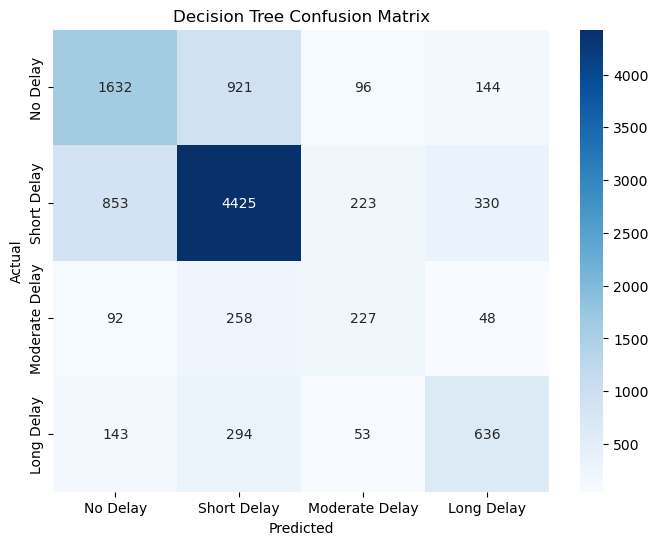

Accuracy: 0.6670
ROC-AUC Score (Macro): 0.7142

Training and evaluating model: Perceptron
Model Perceptron does not support predict_proba. Skipping ROC-AUC.

Classification Report for Perceptron:
                precision    recall  f1-score   support

    Long Delay       0.18      0.13      0.15      1126
Moderate Delay       0.07      0.12      0.09       625
      No Delay       0.49      0.21      0.30      2793
   Short Delay       0.61      0.77      0.68      5831

      accuracy                           0.51     10375
     macro avg       0.34      0.31      0.30     10375
  weighted avg       0.50      0.51      0.48     10375



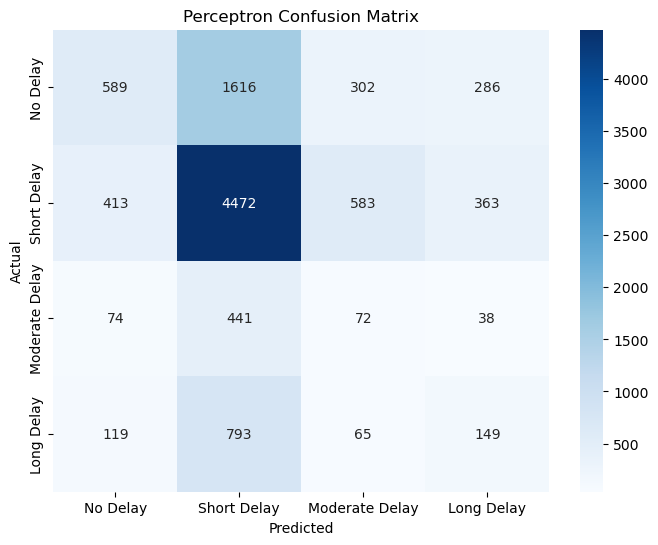

Accuracy: 0.5091
ROC-AUC Score: Not Available

Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best ROC-AUC Score for Random Forest: 0.8203

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Best ROC-AUC Score for Decision Tree: 0.7359

Random Forest Cross-Validation ROC-AUC Scores: [0.83467057 0.83500673 0.82636561 0.82637736 0.83022152]
Average Random Forest ROC-AUC Score: 0.8305

Decision Tree Cross-Validation ROC-AUC Scores: [0.74924325 0.76076434 0.75974052 0.74804261 0.77350171]
Average Decision Tree ROC-AUC Score: 0.7583

Model Comparison:
           Model         

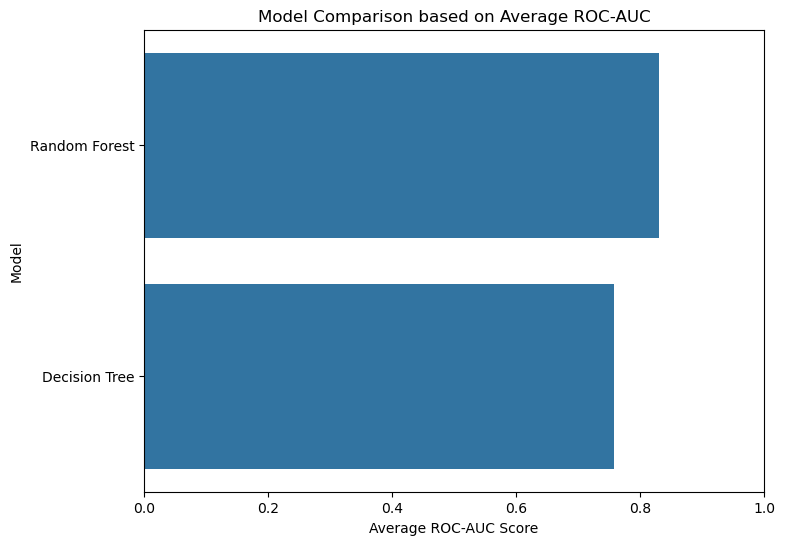


Best Model Selected: Random Forest with Average ROC-AUC Score: 0.8305

Making predictions on the test dataset using the best model: Random Forest

Delay Category Distribution in Test Predictions:
Delay
3    10239
2     3946
0      643
1      154
Name: count, dtype: int64

Trimming submission from 14982 to 12914 entries.
Submission file 'kaggle_submission_classification.csv' saved.
Trained Random Forest model saved as 'best_model_random_forest.pkl'.


In [69]:
# ---------------------------------------------
# Multi-Class Classification Pipeline for Flight Departure Delay Analysis
# Phases: 3 (Analytical and Predictive Tasks), 
#         4 (Model Optimization and Evaluation), 
#         5 (Model Testing and Kaggle Submission)
# ---------------------------------------------

# ---------------------------------------------
# 1. Import Necessary Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_fscore_support

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------
# 2. Load and Inspect Datasets
# ---------------------------------------------
# Replace with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# ---------------------------------------------
# 3. Handle Missing 'departure.actualTime' in Test Dataset
# ---------------------------------------------
# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# ---------------------------------------------
# 4. Datetime Conversion and Feature Engineering
# ---------------------------------------------
# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# ---------------------------------------------
# 5. Feature Engineering: Extract Datetime Features
# ---------------------------------------------
# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday

    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# ---------------------------------------------
# 6. Define Feature Lists
# ---------------------------------------------
# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min',
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min',
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min',
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min',
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday'
    # 'calculated_departure_delay' is REMOVED to prevent data leakage
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# ---------------------------------------------
# 7. Handle Missing Values and Define Preprocessing Pipelines
# ---------------------------------------------
from sklearn.impute import SimpleImputer



# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])


# For scikit-learn >=1.2, use 'sparse_output=False'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
])

# For scikit-learn <1.2, use 'sparse=False'
#categorical_transformer = Pipeline(steps=[
 #   ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
  #  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # One-hot encode categorical features
#)

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ---------------------------------------------
# 8. Define Target Variable for Multi-Class Classification
# ---------------------------------------------
# Define multi-class target variable based on delay minutes
def categorize_delay(minutes):
    if minutes == 0:
        return 'No Delay'
    elif 0 < minutes < 45:
        return 'Short Delay'
    elif 45 <= minutes <= 175:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

train_df['multi_target'] = train_df['departure.delay_minutes'].apply(categorize_delay)

# Verify the distribution
print("\nMulti-Class Target Distribution:")
print(train_df['multi_target'].value_counts())

# Define feature matrix X and target vector y
X = train_df[numeric_features + categorical_features]
y = train_df['multi_target']  # Multi-class target

# Encode target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\nEncoded Target Labels:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Check for missing values in the target variable
missing_targets = y.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the multi-class target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y.dropna().index
    X = X.loc[non_null_indices]
    y_encoded = y_encoded[non_null_indices]
else:
    print("\nNo missing values found in the multi-class target variable.")

# Define feature matrix for test data
X_test = test_df[numeric_features + categorical_features]

# ---------------------------------------------
# 9. Split Data into Training and Validation Sets
# ---------------------------------------------
# Split the data into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("\nTraining Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", X_test.shape)

# ---------------------------------------------
# 10. Phase 3: Analytical and Predictive Tasks
# Multi-Class Classification
# ---------------------------------------------
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Perceptron': Perceptron(random_state=42)
}

# Dictionary to store model performances
model_performance = {}

# Iterate through models, train, and evaluate
for model_name, model in models.items():
    print(f"\nTraining and evaluating model: {model_name}")

    # Create Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on Validation Set
    y_pred = pipeline.predict(X_val)

    # For ROC-AUC, we need probability estimates
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_val)
        # Compute ROC-AUC using one-vs-rest
        roc_auc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, average='macro', multi_class='ovr')
    else:
        # Models without predict_proba
        y_pred_proba = None
        roc_auc = np.nan
        print(f"Model {model_name} does not support predict_proba. Skipping ROC-AUC.")

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(pd.get_dummies(y_val), y_pred_proba, average='macro', multi_class='ovr')
    else:
        roc_auc = np.nan  # Assign NaN if ROC-AUC not available

    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')

    # Store performance
    model_performance[model_name] = {
        'Pipeline': pipeline,
        'Accuracy': accuracy,
        'ROC-AUC (Macro)': roc_auc,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1-Score (Macro)': f1
    }

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=label_encoder.transform(['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay']))
    cm_df = pd.DataFrame(cm, index=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'],
                         columns=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC-AUC Score (Macro): {roc_auc:.4f}")
    else:
        print("ROC-AUC Score: Not Available")

# ---------------------------------------------
# 11. Phase 4: Model Optimization and Evaluation
# Hyperparameter Tuning for Random Forest and Decision Tree
# ---------------------------------------------
# Define parameter grids for Random Forest and Decision Tree
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV for Random Forest
print("\nStarting GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for Random Forest
grid_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print(f"\nBest Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC-AUC Score for Random Forest: {grid_search_rf.best_score_:.4f}")

# Initialize GridSearchCV for Decision Tree
print("\nStarting GridSearchCV for Decision Tree...")
grid_search_dt = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for Decision Tree
grid_search_dt.fit(X_train, y_train)

# Best parameters and score for Decision Tree
print(f"\nBest Parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best ROC-AUC Score for Decision Tree: {grid_search_dt.best_score_:.4f}")

# ---------------------------------------------
# 12. Cross-Validation for Optimized Models
# ---------------------------------------------
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Best Random Forest Model
best_rf = grid_search_rf.best_estimator_
rf_cv_scores = cross_val_score(best_rf, X, y_encoded, cv=skf, scoring='roc_auc_ovr', n_jobs=-1)
print(f"\nRandom Forest Cross-Validation ROC-AUC Scores: {rf_cv_scores}")
print(f"Average Random Forest ROC-AUC Score: {rf_cv_scores.mean():.4f}")

# Best Decision Tree Model
best_dt = grid_search_dt.best_estimator_
dt_cv_scores = cross_val_score(best_dt, X, y_encoded, cv=skf, scoring='roc_auc_ovr', n_jobs=-1)
print(f"\nDecision Tree Cross-Validation ROC-AUC Scores: {dt_cv_scores}")
print(f"Average Decision Tree ROC-AUC Score: {dt_cv_scores.mean():.4f}")

# ---------------------------------------------
# 13. Model Comparison and Selection
# ---------------------------------------------
# Compile cross-validation scores into a DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree'],
    'ROC-AUC Scores': [rf_cv_scores, dt_cv_scores],
    'Average ROC-AUC': [rf_cv_scores.mean(), dt_cv_scores.mean()]
})

print("\nModel Comparison:")
print(comparison_df)

# Plot Average ROC-AUC Scores
plt.figure(figsize=(8,6))
sns.barplot(x='Average ROC-AUC', y='Model', data=comparison_df)
plt.title('Model Comparison based on Average ROC-AUC')
plt.xlabel('Average ROC-AUC Score')
plt.ylabel('Model')
plt.xlim(0,1)
plt.show()

# Select the best model based on average ROC-AUC
if rf_cv_scores.mean() > dt_cv_scores.mean():
    best_model = best_rf
    best_model_name = 'Random Forest'
else:
    best_model = best_dt
    best_model_name = 'Decision Tree'

print(f"\nBest Model Selected: {best_model_name} with Average ROC-AUC Score: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Average ROC-AUC'].values[0]:.4f}")

# ---------------------------------------------
# 14. Phase 5: Model Testing and Kaggle Submission
# Make Predictions on Test Dataset
# ---------------------------------------------
# Predict using the best model
print(f"\nMaking predictions on the test dataset using the best model: {best_model_name}")
y_pred_test_best = best_model.predict(X_test)

# ---------------------------------------------
# 15. Prepare the Submission File
# ---------------------------------------------
# Prepare the Submission DataFrame
submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Adjust if your test set has specific IDs
    'Delay': y_pred_test_best  # Predicted delay categories as strings
})

# Verify the distribution
print("\nDelay Category Distribution in Test Predictions:")
print(submission_df['Delay'].value_counts())

# Ensure the Number of Entries matches the expected number
expected_entries = 12914  # Replace with actual expected number if different
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected number of entries.")

# Save the Submission File in the Required Format
submission_df.to_csv('kaggle_submission_classification.csv', index=False)
print("Submission file 'kaggle_submission_classification.csv' saved.")

# ---------------------------------------------
# 16. Save the Best Model
# ---------------------------------------------
# Save the trained best model using joblib
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)
print(f"Trained {best_model_name} model saved as '{model_filename}'.")


In [71]:
submission_df

,ID,Delay
0,1,2
1,2,2
2,3,0
3,4,2
4,5,2
...,...,...
12909,12910,3
12910,12911,3
12911,12912,3
12912,12913,3


In [83]:
import pandas as pd



# Reverse mapping (assume this is the same mapping used for encoding earlier)
label_mapping = {0: 'Long Delay', 1: 'Moderate Delay', 2: 'No Delay', 3: 'Short Delay'}

# Create a new column with decoded string labels
submission_df['Delay'] = submission_df['Delay'].map(label_mapping)




In [79]:
submission_df=pd.read_csv('kaggle_submission_classification.csv')


In [89]:
submission_df.to_csv("multiclasifcatin_kaggle_22i_1374_ai_c.csv")

In [97]:
submission_df['Delay'].value_counts()


Delay
Short Delay       8792
No Delay          3441
Long Delay         543
Moderate Delay     138
Name: count, dtype: int64